In [1]:
!python -V

Python 3.13.5


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/08/02 12:55:52 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/02 12:55:52 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location=('file:d:/Data Science/Online Courses/MLOps Zoomcamp '
 '(DataTalksClub)/mlops-zoomcamp/02-experiment-tracking/mlruns/1'), creation_time=1754110553427, experiment_id='1', last_update_time=1754110553427, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829628

C:\Users\leehu\AppData\Local\Temp\ipykernel_27492\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\leehu\AppData\Local\Temp\ipykernel_27492\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


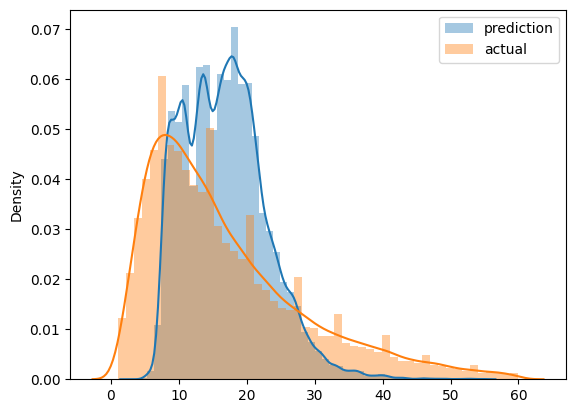

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715205596356

In [ ]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

11.167275941179728

# Basics of mlflow logging

In [31]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "leehui")
    
    mlflow.log_param("train_data_path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val_data_path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [ ]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "leehui")
    
    mlflow.log_param("train_data_path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val_data_path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.1
    
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

In [22]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiments = client.search_experiments()
for exp in experiments:
    print(f"ID={exp.experiment_id}, Name={exp.name}, Artifact Location={exp.artifact_location}")

runs = client.search_runs(experiment_ids=["1"])
for run in runs:
    print(f"Run ID={run.info.run_id}, Status={run.info.status}, Artifact URI={run.info.artifact_uri}")

ID=1, Name=nyc-taxi-experiment, Artifact Location=file:d:/Data Science/Online Courses/MLOps Zoomcamp (DataTalksClub)/mlops-zoomcamp/02-experiment-tracking/mlruns/1
Run ID=91723eb66d3545689e0419f3dd47e95c, Status=FINISHED, Artifact URI=file:d:/Data Science/Online Courses/MLOps Zoomcamp (DataTalksClub)/mlops-zoomcamp/02-experiment-tracking/mlruns/1/91723eb66d3545689e0419f3dd47e95c/artifacts
Run ID=822ca59307b54a58aafb40c47b3b873e, Status=FINISHED, Artifact URI=file:d:/Data Science/Online Courses/MLOps Zoomcamp (DataTalksClub)/mlops-zoomcamp/02-experiment-tracking/mlruns/1/822ca59307b54a58aafb40c47b3b873e/artifacts


# Hyperparameter tuning using hyperopt search spaces + mlflow

In [23]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [27]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [28]:
# https://hyperopt.github.io/hyperopt/getting-started/search_spaces/
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.19885                          
[1]	validation-rmse:10.35490                          
[2]	validation-rmse:9.65913                           
[3]	validation-rmse:9.08206                           
[4]	validation-rmse:8.61034                           
[5]	validation-rmse:8.21863                           
[6]	validation-rmse:7.90907                           
[7]	validation-rmse:7.65241                           
[8]	validation-rmse:7.44668                           
[9]	validation-rmse:7.28259                           
[10]	validation-rmse:7.14930                          
[11]	validation-rmse:7.04525                          
[12]	validation-rmse:6.95181                          
[13]	validation-rmse:6.88618                          
[14]	validation-rmse:6.82686                          
[15]	validation-rmse:6.77652                          
[16]	validation-rmse:6.74161                          
[17]	validation-rmse:6.70599                          
[18]	valid

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.29367                                                      
[1]	validation-rmse:8.99623                                                       
[2]	validation-rmse:8.13933                                                       
[3]	validation-rmse:7.58524                                                       
[4]	validation-rmse:7.23293                                                       
[5]	validation-rmse:7.00924                                                       
[6]	validation-rmse:6.86467                                                       
[7]	validation-rmse:6.77158                                                       
[8]	validation-rmse:6.70673                                                       
[9]	validation-rmse:6.66208                                                       
[10]	validation-rmse:6.63243                                                      
[11]	validation-rmse:6.61018                                                      
[12]

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:33:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:7.28574                                                    
[7]	validation-rmse:7.13935                                                    
[8]	validation-rmse:7.03378                                                    
[9]	validation-rmse:6.95755                                                    
[10]	validation-rmse:6.90316                                                   
[11]	validation-rmse:6.86379                                                   
[12]	validation-rmse:6.83398                                                   
[13]	validation-rmse:6.81297                                                   
[14]	validation-rmse:6.79606                                                   
[15]	validation-rmse:6.78357                                                   
[16]	validation-rmse:6.77219                                                   
[17]	validation-rmse:6.76678                                                   
[18]	validation-rmse:6.75904            

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:34:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.42733                                                   
[1]	validation-rmse:10.74166                                                   
[2]	validation-rmse:10.14594                                                   
[3]	validation-rmse:9.62867                                                    
[4]	validation-rmse:9.18386                                                    
[5]	validation-rmse:8.79962                                                    
[6]	validation-rmse:8.46158                                                    
[7]	validation-rmse:8.18634                                                    
[8]	validation-rmse:7.94304                                                    
[9]	validation-rmse:7.73294                                                    
[10]	validation-rmse:7.55715                                                   
[11]	validation-rmse:7.41377                                                   
[12]	validation-rmse:7.29001            

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.71691                                                     
[1]	validation-rmse:11.26057                                                     
[2]	validation-rmse:10.84108                                                     
[3]	validation-rmse:10.45679                                                     
[4]	validation-rmse:10.10557                                                     
[5]	validation-rmse:9.78409                                                      
[6]	validation-rmse:9.49055                                                      
[7]	validation-rmse:9.22256                                                      
[8]	validation-rmse:8.97904                                                      
[9]	validation-rmse:8.75795                                                      
[10]	validation-rmse:8.55723                                                     
[11]	validation-rmse:8.37512                                                     
[12]	validation-

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.40616                                                   
[1]	validation-rmse:10.70560                                                   
[2]	validation-rmse:10.10008                                                   
[3]	validation-rmse:9.57856                                                    
[4]	validation-rmse:9.13180                                                    
[5]	validation-rmse:8.74955                                                    
[6]	validation-rmse:8.42389                                                    
[7]	validation-rmse:8.14834                                                    
[8]	validation-rmse:7.91534                                                    
[9]	validation-rmse:7.71855                                                    
[10]	validation-rmse:7.55251                                                   
[11]	validation-rmse:7.41282                                                   
[12]	validation-rmse:7.29535            

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:6.72140                                                      
[5]	validation-rmse:6.71751                                                      
[6]	validation-rmse:6.71098                                                      
[7]	validation-rmse:6.70806                                                      
[8]	validation-rmse:6.70501                                                      
[9]	validation-rmse:6.70099                                                      
[10]	validation-rmse:6.69919                                                     
[11]	validation-rmse:6.69553                                                     
[12]	validation-rmse:6.69228                                                     
[13]	validation-rmse:6.69081                                                     
[14]	validation-rmse:6.68804                                                     
[15]	validation-rmse:6.68579                                                     
[16]	validation-

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.42379                                                   
[1]	validation-rmse:10.73227                                                   
[2]	validation-rmse:10.13790                                                   
[3]	validation-rmse:9.61766                                                    
[4]	validation-rmse:9.16954                                                    
[5]	validation-rmse:8.78391                                                    
[6]	validation-rmse:8.45062                                                    
[7]	validation-rmse:8.16779                                                    
[8]	validation-rmse:7.92672                                                    
[9]	validation-rmse:7.72218                                                    
[10]	validation-rmse:7.54843                                                   
[11]	validation-rmse:7.40387                                                   
[12]	validation-rmse:7.27847            

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:42:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.77090                                                      
[1]	validation-rmse:7.41231                                                      
[2]	validation-rmse:6.92124                                                      
[3]	validation-rmse:6.73376                                                      
[4]	validation-rmse:6.64971                                                      
[5]	validation-rmse:6.61035                                                      
[6]	validation-rmse:6.58878                                                      
[7]	validation-rmse:6.58033                                                      
[8]	validation-rmse:6.57770                                                      
[9]	validation-rmse:6.57401                                                      
[10]	validation-rmse:6.56833                                                     
[11]	validation-rmse:6.55981                                                     
[12]	validation-

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.70861                                                 
[1]	validation-rmse:8.29811                                                 
[2]	validation-rmse:7.54540                                                 
[3]	validation-rmse:7.15025                                                 
[4]	validation-rmse:6.94463                                                 
[5]	validation-rmse:6.83349                                                 
[6]	validation-rmse:6.76583                                                 
[7]	validation-rmse:6.72703                                                 
[8]	validation-rmse:6.70184                                                 
[9]	validation-rmse:6.68309                                                 
[10]	validation-rmse:6.67011                                                
[11]	validation-rmse:6.66206                                                
[12]	validation-rmse:6.65309                                                

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:43:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.97463                                                  
[1]	validation-rmse:7.51917                                                  
[2]	validation-rmse:6.91229                                                  
[3]	validation-rmse:6.65731                                                  
[4]	validation-rmse:6.55103                                                  
[5]	validation-rmse:6.48840                                                  
[6]	validation-rmse:6.46284                                                  
[7]	validation-rmse:6.44237                                                  
[8]	validation-rmse:6.43040                                                  
[9]	validation-rmse:6.42235                                                  
[10]	validation-rmse:6.41822                                                 
[11]	validation-rmse:6.41486                                                 
[12]	validation-rmse:6.41152                                    

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.64289                                                  
[1]	validation-rmse:6.59307                                                  
[2]	validation-rmse:6.57600                                                  
[3]	validation-rmse:6.56933                                                  
[4]	validation-rmse:6.56120                                                  
[5]	validation-rmse:6.55335                                                  
[6]	validation-rmse:6.54074                                                  
[7]	validation-rmse:6.53253                                                  
[8]	validation-rmse:6.52356                                                  
[9]	validation-rmse:6.52195                                                  
[10]	validation-rmse:6.51314                                                 
[11]	validation-rmse:6.50639                                                 
[12]	validation-rmse:6.50390                                    

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.27343                                                 
[1]	validation-rmse:10.47831                                                 
[2]	validation-rmse:9.80923                                                  
[3]	validation-rmse:9.24672                                                  
[4]	validation-rmse:8.77789                                                  
[5]	validation-rmse:8.39532                                                  
[6]	validation-rmse:8.06957                                                  
[7]	validation-rmse:7.81024                                                  
[8]	validation-rmse:7.58799                                                  
[9]	validation-rmse:7.41408                                                  
[10]	validation-rmse:7.26402                                                 
[11]	validation-rmse:7.14631                                                 
[12]	validation-rmse:7.05308                                    

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.50158                                                 
[1]	validation-rmse:10.87295                                                 
[2]	validation-rmse:10.31818                                                 
[3]	validation-rmse:9.82951                                                  
[4]	validation-rmse:9.40261                                                  
[5]	validation-rmse:9.02830                                                  
[6]	validation-rmse:8.70560                                                  
[7]	validation-rmse:8.41598                                                  
[8]	validation-rmse:8.17216                                                  
[9]	validation-rmse:7.95674                                                  
[10]	validation-rmse:7.77440                                                 
[11]	validation-rmse:7.61535                                                 
[12]	validation-rmse:7.47840                                    

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.65862                                                 
[1]	validation-rmse:11.15321                                                 
[2]	validation-rmse:10.69450                                                 
[3]	validation-rmse:10.27773                                                 
[4]	validation-rmse:9.89964                                                  
[5]	validation-rmse:9.55836                                                  
[6]	validation-rmse:9.24841                                                  
[7]	validation-rmse:8.97193                                                  
[8]	validation-rmse:8.72137                                                  
[9]	validation-rmse:8.49628                                                  
[10]	validation-rmse:8.29517                                                 
[11]	validation-rmse:8.11470                                                 
[12]	validation-rmse:7.95088                                    

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.26967                                                  
[1]	validation-rmse:7.78506                                                  
[2]	validation-rmse:7.08792                                                  
[3]	validation-rmse:6.75925                                                  
[4]	validation-rmse:6.60591                                                  
[5]	validation-rmse:6.52803                                                  
[6]	validation-rmse:6.48303                                                  
[7]	validation-rmse:6.45672                                                  
[8]	validation-rmse:6.43839                                                  
[9]	validation-rmse:6.42689                                                  
[10]	validation-rmse:6.41871                                                 
[11]	validation-rmse:6.41300                                                 
[12]	validation-rmse:6.40829                                    

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.44060                                                 
[1]	validation-rmse:10.76237                                                 
[2]	validation-rmse:10.16956                                                 
[3]	validation-rmse:9.65104                                                  
[4]	validation-rmse:9.20162                                                  
[5]	validation-rmse:8.81112                                                  
[6]	validation-rmse:8.47330                                                  
[7]	validation-rmse:8.18283                                                  
[8]	validation-rmse:7.93273                                                  
[9]	validation-rmse:7.71836                                                  
[10]	validation-rmse:7.53548                                                 
[11]	validation-rmse:7.38029                                                 
[12]	validation-rmse:7.24792                                    

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.56370                                                  
[1]	validation-rmse:8.14157                                                  
[2]	validation-rmse:7.41965                                                  
[3]	validation-rmse:7.06004                                                  
[4]	validation-rmse:6.88022                                                  
[5]	validation-rmse:6.77765                                                  
[6]	validation-rmse:6.72067                                                  
[7]	validation-rmse:6.68397                                                  
[8]	validation-rmse:6.66151                                                  
[9]	validation-rmse:6.64609                                                  
[10]	validation-rmse:6.63604                                                 
[11]	validation-rmse:6.62756                                                 
[12]	validation-rmse:6.62132                                    

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.23761                                                  
[1]	validation-rmse:6.73783                                                  
[2]	validation-rmse:6.66269                                                  
[3]	validation-rmse:6.64338                                                  
[4]	validation-rmse:6.63266                                                  
[5]	validation-rmse:6.63210                                                  
[6]	validation-rmse:6.62681                                                  
[7]	validation-rmse:6.62029                                                  
[8]	validation-rmse:6.61361                                                  
[9]	validation-rmse:6.60799                                                  
[10]	validation-rmse:6.60309                                                 
[11]	validation-rmse:6.58739                                                 
[12]	validation-rmse:6.58637                                    

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.75875                                                  
[1]	validation-rmse:7.39602                                                  
[2]	validation-rmse:6.89762                                                  
[3]	validation-rmse:6.70675                                                  
[4]	validation-rmse:6.62523                                                  
[5]	validation-rmse:6.58446                                                  
[6]	validation-rmse:6.56501                                                  
[7]	validation-rmse:6.55288                                                  
[8]	validation-rmse:6.54235                                                  
[9]	validation-rmse:6.53764                                                  
[10]	validation-rmse:6.53147                                                 
[11]	validation-rmse:6.52709                                                 
[12]	validation-rmse:6.52261                                    

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.50286                                                 
[1]	validation-rmse:9.28382                                                  
[2]	validation-rmse:8.43223                                                  
[3]	validation-rmse:7.85299                                                  
[4]	validation-rmse:7.45764                                                  
[5]	validation-rmse:7.19266                                                  
[6]	validation-rmse:7.01456                                                  
[7]	validation-rmse:6.89262                                                  
[8]	validation-rmse:6.80799                                                  
[9]	validation-rmse:6.74786                                                  
[10]	validation-rmse:6.70504                                                 
[11]	validation-rmse:6.67598                                                 
[12]	validation-rmse:6.65482                                    

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.82857                                                    
[1]	validation-rmse:9.76244                                                     
[2]	validation-rmse:8.95153                                                     
[3]	validation-rmse:8.34344                                                     
[4]	validation-rmse:7.89341                                                     
[5]	validation-rmse:7.55995                                                     
[6]	validation-rmse:7.31847                                                     
[7]	validation-rmse:7.14096                                                     
[8]	validation-rmse:7.00871                                                     
[9]	validation-rmse:6.91083                                                     
[10]	validation-rmse:6.83806                                                    
[11]	validation-rmse:6.78166                                                    
[12]	validation-rmse:6.73932

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.90719                                                    
[1]	validation-rmse:9.88618                                                     
[2]	validation-rmse:9.09576                                                     
[3]	validation-rmse:8.49126                                                     
[4]	validation-rmse:8.03444                                                     
[5]	validation-rmse:7.68810                                                     
[6]	validation-rmse:7.42900                                                     
[7]	validation-rmse:7.23526                                                     
[8]	validation-rmse:7.09175                                                     
[9]	validation-rmse:6.98339                                                     
[10]	validation-rmse:6.90010                                                    
[11]	validation-rmse:6.83917                                                    
[12]	validation-rmse:6.79045

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.12573                                                    
[1]	validation-rmse:8.77633                                                     
[2]	validation-rmse:7.93319                                                     
[3]	validation-rmse:7.41648                                                     
[4]	validation-rmse:7.10452                                                     
[5]	validation-rmse:6.91399                                                     
[6]	validation-rmse:6.79656                                                     
[7]	validation-rmse:6.72231                                                     
[8]	validation-rmse:6.67263                                                     
[9]	validation-rmse:6.64063                                                     
[10]	validation-rmse:6.61792                                                    
[11]	validation-rmse:6.60305                                                    
[12]	validation-rmse:6.59086

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.90686                                                    
[1]	validation-rmse:9.87465                                                     
[2]	validation-rmse:9.07027                                                     
[3]	validation-rmse:8.44637                                                     
[4]	validation-rmse:7.97142                                                     
[5]	validation-rmse:7.60872                                                     
[6]	validation-rmse:7.33494                                                     
[7]	validation-rmse:7.12995                                                     
[8]	validation-rmse:6.97374                                                     
[9]	validation-rmse:6.85618                                                     
[10]	validation-rmse:6.76803                                                    
[11]	validation-rmse:6.69843                                                    
[12]	validation-rmse:6.64559

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.58696                                                    
[1]	validation-rmse:9.39709                                                     
[2]	validation-rmse:8.53722                                                     
[3]	validation-rmse:7.93038                                                     
[4]	validation-rmse:7.50440                                                     
[5]	validation-rmse:7.21189                                                     
[6]	validation-rmse:7.00483                                                     
[7]	validation-rmse:6.86355                                                     
[8]	validation-rmse:6.76268                                                     
[9]	validation-rmse:6.69089                                                     
[10]	validation-rmse:6.63813                                                    
[11]	validation-rmse:6.59999                                                    
[12]	validation-rmse:6.57181

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.97678                                                     
[1]	validation-rmse:8.59144                                                     
[2]	validation-rmse:7.77325                                                     
[3]	validation-rmse:7.29511                                                     
[4]	validation-rmse:7.01944                                                     
[5]	validation-rmse:6.85831                                                     
[6]	validation-rmse:6.76316                                                     
[7]	validation-rmse:6.69733                                                     
[8]	validation-rmse:6.65976                                                     
[9]	validation-rmse:6.63529                                                     
[10]	validation-rmse:6.61425                                                    
[11]	validation-rmse:6.60141                                                    
[12]	validation-rmse:6.59401

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.06606                                                     
[1]	validation-rmse:6.96810                                                     
[2]	validation-rmse:6.69048                                                     
[3]	validation-rmse:6.59910                                                     
[4]	validation-rmse:6.56374                                                     
[5]	validation-rmse:6.54885                                                     
[6]	validation-rmse:6.53937                                                     
[7]	validation-rmse:6.53021                                                     
[8]	validation-rmse:6.52028                                                     
[9]	validation-rmse:6.51543                                                     
[10]	validation-rmse:6.51077                                                    
[11]	validation-rmse:6.50623                                                    
[12]	validation-rmse:6.50128

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:7.08144                                                     
[6]	validation-rmse:6.98338                                                     
[7]	validation-rmse:6.92101                                                     
[8]	validation-rmse:6.88137                                                     
[9]	validation-rmse:6.85726                                                     
[10]	validation-rmse:6.83987                                                    
[11]	validation-rmse:6.83027                                                    
[12]	validation-rmse:6.82125                                                    
[13]	validation-rmse:6.81832                                                    
[14]	validation-rmse:6.80685                                                    
[15]	validation-rmse:6.80276                                                    
[16]	validation-rmse:6.79973                                                    
[17]	validation-rmse:6.79560

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.03235                                                    
[1]	validation-rmse:10.07896                                                    
[2]	validation-rmse:9.31235                                                     
[3]	validation-rmse:8.70409                                                     
[4]	validation-rmse:8.22480                                                     
[5]	validation-rmse:7.85024                                                     
[6]	validation-rmse:7.55714                                                     
[7]	validation-rmse:7.33093                                                     
[8]	validation-rmse:7.15378                                                     
[9]	validation-rmse:7.01807                                                     
[10]	validation-rmse:6.90909                                                    
[11]	validation-rmse:6.82716                                                    
[12]	validation-rmse:6.76128

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80879                                                    
[1]	validation-rmse:11.43135                                                    
[2]	validation-rmse:11.07802                                                    
[3]	validation-rmse:10.74886                                                    
[4]	validation-rmse:10.44267                                                    
[5]	validation-rmse:10.15816                                                    
[6]	validation-rmse:9.89240                                                     
[7]	validation-rmse:9.64563                                                     
[8]	validation-rmse:9.41652                                                     
[9]	validation-rmse:9.20397                                                     
[10]	validation-rmse:9.00697                                                    
[11]	validation-rmse:8.82437                                                    
[12]	validation-rmse:8.65664

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.42921                                                    
[1]	validation-rmse:9.18627                                                     
[2]	validation-rmse:8.34199                                                     
[3]	validation-rmse:7.77893                                                     
[4]	validation-rmse:7.40918                                                     
[5]	validation-rmse:7.16527                                                     
[6]	validation-rmse:7.00480                                                     
[7]	validation-rmse:6.90019                                                     
[8]	validation-rmse:6.82627                                                     
[9]	validation-rmse:6.77604                                                     
[10]	validation-rmse:6.74178                                                    
[11]	validation-rmse:6.71558                                                    
[12]	validation-rmse:6.69737

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:04:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.03660                                                     
[1]	validation-rmse:7.01349                                                     
[2]	validation-rmse:6.76678                                                     
[3]	validation-rmse:6.69361                                                     
[4]	validation-rmse:6.66463                                                     
[5]	validation-rmse:6.64969                                                     
[6]	validation-rmse:6.64762                                                     
[7]	validation-rmse:6.64301                                                     
[8]	validation-rmse:6.63926                                                     
[9]	validation-rmse:6.63590                                                     
[10]	validation-rmse:6.62924                                                    
[11]	validation-rmse:6.62341                                                    
[12]	validation-rmse:6.61996

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:04:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.15969                                                    
[1]	validation-rmse:10.28918                                                    
[2]	validation-rmse:9.57419                                                     
[3]	validation-rmse:8.99057                                                     
[4]	validation-rmse:8.51844                                                     
[5]	validation-rmse:8.13726                                                     
[6]	validation-rmse:7.83197                                                     
[7]	validation-rmse:7.58913                                                     
[8]	validation-rmse:7.39437                                                     
[9]	validation-rmse:7.23970                                                     
[10]	validation-rmse:7.11733                                                    
[11]	validation-rmse:7.01982                                                    
[12]	validation-rmse:6.94205

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:05:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:7.11317                                                     
[7]	validation-rmse:7.01764                                                     
[8]	validation-rmse:6.95311                                                     
[9]	validation-rmse:6.91175                                                     
[10]	validation-rmse:6.88295                                                    
[11]	validation-rmse:6.86080                                                    
[12]	validation-rmse:6.84503                                                    
[13]	validation-rmse:6.83584                                                    
[14]	validation-rmse:6.82609                                                    
[15]	validation-rmse:6.82065                                                    
[16]	validation-rmse:6.81330                                                    
[17]	validation-rmse:6.80973                                                    
[18]	validation-rmse:6.80754

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.87514                                                     
[1]	validation-rmse:8.48242                                                     
[2]	validation-rmse:7.66890                                                     
[3]	validation-rmse:7.20509                                                     
[4]	validation-rmse:6.94543                                                     
[5]	validation-rmse:6.80255                                                     
[6]	validation-rmse:6.70349                                                     
[7]	validation-rmse:6.64813                                                     
[8]	validation-rmse:6.60047                                                     
[9]	validation-rmse:6.57778                                                     
[10]	validation-rmse:6.55860                                                    
[11]	validation-rmse:6.54565                                                    
[12]	validation-rmse:6.54133

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:07:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.21327                                                     
[1]	validation-rmse:7.02316                                                     
[2]	validation-rmse:6.68702                                                     
[3]	validation-rmse:6.57638                                                     
[4]	validation-rmse:6.53679                                                     
[5]	validation-rmse:6.51619                                                     
[6]	validation-rmse:6.50004                                                     
[7]	validation-rmse:6.49256                                                     
[8]	validation-rmse:6.48334                                                     
[9]	validation-rmse:6.47743                                                     
[10]	validation-rmse:6.47305                                                    
[11]	validation-rmse:6.46802                                                    
[12]	validation-rmse:6.46323

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:07:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.54301                                                     
[2]	validation-rmse:8.72040                                                     
[3]	validation-rmse:8.13071                                                     
[4]	validation-rmse:7.71430                                                     
[5]	validation-rmse:7.41950                                                     
[6]	validation-rmse:7.21771                                                     
[7]	validation-rmse:7.07473                                                     
[8]	validation-rmse:6.97269                                                     
[9]	validation-rmse:6.89886                                                     
[10]	validation-rmse:6.84726                                                    
[11]	validation-rmse:6.80960                                                    
[12]	validation-rmse:6.78267                                                    
[13]	validation-rmse:6.76361

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:08:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.22952                                                    
[1]	validation-rmse:10.40630                                                    
[2]	validation-rmse:9.71751                                                     
[3]	validation-rmse:9.14829                                                     
[4]	validation-rmse:8.67888                                                     
[5]	validation-rmse:8.29478                                                     
[6]	validation-rmse:7.98048                                                     
[7]	validation-rmse:7.72731                                                     
[8]	validation-rmse:7.51784                                                     
[9]	validation-rmse:7.34967                                                     
[10]	validation-rmse:7.21337                                                    
[11]	validation-rmse:7.10303                                                    
[12]	validation-rmse:7.01245

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:09:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.80493                                                     
[1]	validation-rmse:8.39023                                                     
[2]	validation-rmse:7.59447                                                     
[3]	validation-rmse:7.15874                                                     
[4]	validation-rmse:6.91861                                                     
[5]	validation-rmse:6.78207                                                     
[6]	validation-rmse:6.70217                                                     
[7]	validation-rmse:6.65495                                                     
[8]	validation-rmse:6.62438                                                     
[9]	validation-rmse:6.60108                                                     
[10]	validation-rmse:6.58706                                                    
[11]	validation-rmse:6.57665                                                    
[12]	validation-rmse:6.56818

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.19897                                                     
[1]	validation-rmse:7.81062                                                     
[2]	validation-rmse:7.21618                                                     
[3]	validation-rmse:6.95876                                                     
[4]	validation-rmse:6.84560                                                     
[5]	validation-rmse:6.78723                                                     
[6]	validation-rmse:6.75232                                                     
[7]	validation-rmse:6.73122                                                     
[8]	validation-rmse:6.71302                                                     
[9]	validation-rmse:6.70424                                                     
[10]	validation-rmse:6.69947                                                    
[11]	validation-rmse:6.69466                                                    
[12]	validation-rmse:6.69265

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.62076                                                    
[1]	validation-rmse:11.08551                                                    
[2]	validation-rmse:10.60339                                                    
[3]	validation-rmse:10.17005                                                    
[4]	validation-rmse:9.78096                                                     
[5]	validation-rmse:9.43352                                                     
[6]	validation-rmse:9.12286                                                     
[7]	validation-rmse:8.84632                                                     
[8]	validation-rmse:8.59911                                                     
[9]	validation-rmse:8.38084                                                     
[10]	validation-rmse:8.18569                                                    
[11]	validation-rmse:8.01320                                                    
[12]	validation-rmse:7.86193

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:6.72311                                                     
[6]	validation-rmse:6.71394                                                     
[7]	validation-rmse:6.70492                                                     
[8]	validation-rmse:6.69880                                                     
[9]	validation-rmse:6.69495                                                     
[10]	validation-rmse:6.69135                                                    
[11]	validation-rmse:6.68777                                                    
[12]	validation-rmse:6.68593                                                    
[13]	validation-rmse:6.68104                                                    
[14]	validation-rmse:6.67618                                                    
[15]	validation-rmse:6.66959                                                    
[16]	validation-rmse:6.66523                                                    
[17]	validation-rmse:6.66066

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.72578                                                     
[1]	validation-rmse:6.66697                                                     
[2]	validation-rmse:6.63129                                                     
[3]	validation-rmse:6.60824                                                     
[4]	validation-rmse:6.59756                                                     
[5]	validation-rmse:6.57781                                                     
[6]	validation-rmse:6.57014                                                     
[7]	validation-rmse:6.56549                                                     
[8]	validation-rmse:6.55951                                                     
[9]	validation-rmse:6.55160                                                     
[10]	validation-rmse:6.54511                                                    
[11]	validation-rmse:6.54368                                                    
[12]	validation-rmse:6.53763

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.06524                                                    
[1]	validation-rmse:10.13097                                                    
[2]	validation-rmse:9.37538                                                     
[3]	validation-rmse:8.77127                                                     
[4]	validation-rmse:8.28754                                                     
[5]	validation-rmse:7.90681                                                     
[6]	validation-rmse:7.60819                                                     
[7]	validation-rmse:7.37499                                                     
[8]	validation-rmse:7.19012                                                     
[9]	validation-rmse:7.04769                                                     
[10]	validation-rmse:6.93482                                                    
[11]	validation-rmse:6.84588                                                    
[12]	validation-rmse:6.77382

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79611                                                     
[1]	validation-rmse:11.40643                                                     
[2]	validation-rmse:11.04253                                                     
[3]	validation-rmse:10.70326                                                     
[4]	validation-rmse:10.38717                                                     
[5]	validation-rmse:10.09306                                                     
[6]	validation-rmse:9.81956                                                      
[7]	validation-rmse:9.56524                                                      
[8]	validation-rmse:9.32977                                                      
[9]	validation-rmse:9.11101                                                      
[10]	validation-rmse:8.90838                                                     
[11]	validation-rmse:8.72122                                                     
[12]	validation-

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.56632                                                     
[1]	validation-rmse:10.98794                                                     
[2]	validation-rmse:10.47131                                                     
[3]	validation-rmse:10.01187                                                     
[4]	validation-rmse:9.60211                                                      
[5]	validation-rmse:9.24003                                                      
[6]	validation-rmse:8.91717                                                      
[7]	validation-rmse:8.63411                                                      
[8]	validation-rmse:8.38566                                                      
[9]	validation-rmse:8.15858                                                      
[10]	validation-rmse:7.96706                                                     
[11]	validation-rmse:7.79633                                                     
[12]	validation-

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.74033                                                     
[1]	validation-rmse:11.30319                                                     
[2]	validation-rmse:10.89921                                                     
[3]	validation-rmse:10.52602                                                     
[4]	validation-rmse:10.18201                                                     
[5]	validation-rmse:9.86596                                                      
[6]	validation-rmse:9.57473                                                      
[7]	validation-rmse:9.30692                                                      
[8]	validation-rmse:9.06170                                                      
[9]	validation-rmse:8.83642                                                      
[10]	validation-rmse:8.63126                                                     
[11]	validation-rmse:8.44301                                                     
[12]	validation-

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.13239                                                     
[1]	validation-rmse:10.23813                                                     
[2]	validation-rmse:9.50298                                                      
[3]	validation-rmse:8.90235                                                      
[4]	validation-rmse:8.41689                                                      
[5]	validation-rmse:8.02586                                                      
[6]	validation-rmse:7.71271                                                      
[7]	validation-rmse:7.46227                                                      
[8]	validation-rmse:7.26288                                                      
[9]	validation-rmse:7.10613                                                      
[10]	validation-rmse:6.98029                                                     
[11]	validation-rmse:6.87995                                                     
[12]	validation-

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.36402                                                      
[1]	validation-rmse:10.63301                                                      
[2]	validation-rmse:10.01095                                                      
[3]	validation-rmse:9.46893                                                       
[4]	validation-rmse:9.02012                                                       
[5]	validation-rmse:8.63179                                                       
[6]	validation-rmse:8.30297                                                       
[7]	validation-rmse:8.02807                                                       
[8]	validation-rmse:7.79430                                                       
[9]	validation-rmse:7.60165                                                       
[10]	validation-rmse:7.44135                                                      
[11]	validation-rmse:7.30375                                                      
[12]

# Logging model with mlflow autolog

In [ ]:
# Saving best experiment run with autolog
# https://mlflow.org/docs/latest/ml/tracking/autolog/
params = {
    'learning_rate': 0.14273346553937505,
    'max_depth': 51,
    'min_child_weight': 1.500237362607893,
    'objective': 'reg:linear',
    'reg_alpha': 0.0507855287920376,
    'reg_lambda': 0.1717683683586883,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

2025/08/02 14:27:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '94ac10512968404cabd9711307e90660', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:27:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.06524
[1]	validation-rmse:10.13097
[2]	validation-rmse:9.37538
[3]	validation-rmse:8.77127
[4]	validation-rmse:8.28754
[5]	validation-rmse:7.90681
[6]	validation-rmse:7.60819
[7]	validation-rmse:7.37499
[8]	validation-rmse:7.19012
[9]	validation-rmse:7.04769
[10]	validation-rmse:6.93482
[11]	validation-rmse:6.84588
[12]	validation-rmse:6.77382
[13]	validation-rmse:6.71837
[14]	validation-rmse:6.67369
[15]	validation-rmse:6.63580
[16]	validation-rmse:6.60599
[17]	validation-rmse:6.58207
[18]	validation-rmse:6.56145
[19]	validation-rmse:6.54370
[20]	validation-rmse:6.52894
[21]	validation-rmse:6.51717
[22]	validation-rmse:6.50660
[23]	validation-rmse:6.49782
[24]	validation-rmse:6.49041
[25]	validation-rmse:6.48314
[26]	validation-rmse:6.47666
[27]	validation-rmse:6.47115
[28]	validation-rmse:6.46672
[29]	validation-rmse:6.46375
[30]	validation-rmse:6.46045
[31]	validation-rmse:6.45856
[32]	validation-rmse:6.45561
[33]	validation-rmse:6.45393
[34]	validation-rmse:6

2025/08/02 14:29:17 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/08/02 14:29:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:29:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/08/02 14:29:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Logging Artifacts (e.g. prepreprocessor) and Models 

In [33]:
mlflow.xgboost.autolog(disable=True)

In [35]:
# Saving model pickle as artifact
with mlflow.start_run():
    best_params = {
        'learning_rate': 0.14273346553937505,
        'max_depth': 51,
        'min_child_weight': 1.500237362607893,
        'objective': 'reg:linear',
        'reg_alpha': 0.0507855287920376,
        'reg_lambda': 0.1717683683586883,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.06524
[1]	validation-rmse:10.13097
[2]	validation-rmse:9.37538
[3]	validation-rmse:8.77127
[4]	validation-rmse:8.28754
[5]	validation-rmse:7.90681
[6]	validation-rmse:7.60819
[7]	validation-rmse:7.37499
[8]	validation-rmse:7.19012
[9]	validation-rmse:7.04769
[10]	validation-rmse:6.93482
[11]	validation-rmse:6.84588
[12]	validation-rmse:6.77382
[13]	validation-rmse:6.71837
[14]	validation-rmse:6.67369
[15]	validation-rmse:6.63580
[16]	validation-rmse:6.60599
[17]	validation-rmse:6.58207
[18]	validation-rmse:6.56145
[19]	validation-rmse:6.54370
[20]	validation-rmse:6.52894
[21]	validation-rmse:6.51717
[22]	validation-rmse:6.50660
[23]	validation-rmse:6.49782
[24]	validation-rmse:6.49041
[25]	validation-rmse:6.48314
[26]	validation-rmse:6.47666
[27]	validation-rmse:6.47115
[28]	validation-rmse:6.46672
[29]	validation-rmse:6.46375
[30]	validation-rmse:6.46045
[31]	validation-rmse:6.45856
[32]	validation-rmse:6.45561
[33]	validation-rmse:6.45393
[34]	validation-rmse:6

c:\Users\leehu\anaconda3\envs\exp-tracking-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/08/02 14:54:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Make predictions with logged model

In [ ]:
### METHOD 1: Python function model
logged_model = 'runs:/1fdaf228490f4e6eb9c60087dd728277/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [37]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 1fdaf228490f4e6eb9c60087dd728277

In [ ]:
### METHOD 2: XGBoost model
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

In [39]:
xgboost_model.predict(valid)

array([14.222222 ,  7.0271125, 14.534054 , ..., 13.437305 ,  6.3533945,
        7.9670987], shape=(61921,), dtype=float32)

# Model Registry & MLflow Python API

In [40]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

C:\Users\leehu\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [41]:
from mlflow.tracking import MlflowClient


MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [43]:
client.search_experiments()

[<Experiment: artifact_location=('file:d:/Data Science/Online Courses/MLOps Zoomcamp '
  '(DataTalksClub)/mlops-zoomcamp/02-experiment-tracking/mlruns/1'), creation_time=1754110553427, experiment_id='1', last_update_time=1754110553427, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>]

In [ ]:
# client.create_experiment("name_of_experiment")

In [52]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids=["1"],
    filter_string="metrics.rmse < 7.0",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
)

runs

[<Run: data=<RunData: metrics={'rmse': 6.3052479609260095}, params={'learning_rate': '0.14273346553937505',
  'max_depth': '51',
  'min_child_weight': '1.500237362607893',
  'objective': 'reg:linear',
  'reg_alpha': '0.0507855287920376',
  'reg_lambda': '0.1717683683586883',
  'seed': '42'}, tags={'mlflow.log-model.history': '[{"run_id": "1fdaf228490f4e6eb9c60087dd728277", '
                              '"artifact_path": "models_mlflow", '
                              '"utc_time_created": "2025-08-02 '
                              '06:54:02.907584", "model_uuid": '
                              '"266da0c84de34b12befc4bea16945b6c", "flavors": '
                              '{"python_function": {"loader_module": '
                              '"mlflow.xgboost", "python_version": "3.13.5", '
                              '"data": "model.xgb", "env": {"conda": '
                              '"conda.yaml", "virtualenv": "python_env.yaml"}}, '
                              '"xgboost": 

In [54]:
for run in runs:
    print(f"Run ID={run.info.run_id}, RMSE={run.data.metrics['rmse']}")

Run ID=1fdaf228490f4e6eb9c60087dd728277, RMSE=6.3052479609260095
Run ID=4d523161c64d4ba7976e58f1e3330d3f, RMSE=6.3052479609260095
Run ID=b3f56fb4e25649f2ab603ed8e946ca91, RMSE=6.3052479609260095
Run ID=ba689ba3e3e04b6b975bd6a8ac5a2144, RMSE=6.305639479736642
Run ID=cfb3455861e74cf3adaf648776453587, RMSE=6.307025006139384


In [57]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")

run_id = "cfb3455861e74cf3adaf648776453587"
model_uri = f"runs:/{run_id}/model"

mlflow.register_model(
    model_uri=model_uri,
    name="nyc-taxi-regressor",
    tags={'model': 'xgboost', 'stage':'staging'}
)

Registered model 'nyc-taxi-regressor' already exists. Creating a new version of this model...
Created version '4' of model 'nyc-taxi-regressor'.


<ModelVersion: aliases=[], creation_timestamp=1754217212041, current_stage='None', description=None, last_updated_timestamp=1754217212041, name='nyc-taxi-regressor', run_id='cfb3455861e74cf3adaf648776453587', run_link=None, source=('file:d:/Data Science/Online Courses/MLOps Zoomcamp '
 '(DataTalksClub)/mlops-zoomcamp/02-experiment-tracking/mlruns/1/cfb3455861e74cf3adaf648776453587/artifacts/model'), status='READY', status_message=None, tags={'model': 'xgboost', 'stage': 'staging'}, user_id=None, version=4>

In [58]:
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1754213609733, description='The NYC Taxi Predictor for Trip Duration.', last_updated_timestamp=1754217212041, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1754217212041, current_stage='None', description=None, last_updated_timestamp=1754217212041, name='nyc-taxi-regressor', run_id='cfb3455861e74cf3adaf648776453587', run_link=None, source=('file:d:/Data Science/Online Courses/MLOps Zoomcamp '
  '(DataTalksClub)/mlops-zoomcamp/02-experiment-tracking/mlruns/1/cfb3455861e74cf3adaf648776453587/artifacts/model'), status='READY', status_message=None, tags={'model': 'xgboost', 'stage': 'staging'}, user_id=None, version=4>], name='nyc-taxi-regressor', tags={}>]

In [74]:
model_name = "nyc-taxi-regressor"
latest_versions = client.search_model_versions(filter_string=f"name='{model_name}'")

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.tags['stage']}, run_id: {version.run_id}")

version: 4, stage: staging, run_id: cfb3455861e74cf3adaf648776453587
version: 3, stage: archived, run_id: cfb3455861e74cf3adaf648776453587
version: 2, stage: staging, run_id: 0e06b498aa2c4d1abd1f47a8a53e0e8c
version: 1, stage: staging, run_id: 1fdaf228490f4e6eb9c60087dd728277


C:\Users\leehu\AppData\Local\Temp\ipykernel_27492\2513332230.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1754217212041, current_stage='Production', description=None, last_updated_timestamp=1754217571959, name='nyc-taxi-regressor', run_id='cfb3455861e74cf3adaf648776453587', run_link=None, source=('file:d:/Data Science/Online Courses/MLOps Zoomcamp '
 '(DataTalksClub)/mlops-zoomcamp/02-experiment-tracking/mlruns/1/cfb3455861e74cf3adaf648776453587/artifacts/model'), status='READY', status_message=None, tags={'model': 'xgboost', 'stage': 'staging'}, user_id=None, version=4>

In [80]:
from datetime import datetime

date = datetime.today().date()

model_version = 4 
new_stage = "Staging"

### STAGING IS DEPRECATED!!!
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=True)

client.update_model_version(
    name=model_name,
    version=model_version,
    description=f"The model version {model_version} was transited to {new_stage} on {date}",
)

C:\Users\leehu\AppData\Local\Temp\ipykernel_27492\1852408083.py:9: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1754217212041, current_stage='Staging', description='The model version 4 was transited to Staging on 2025-08-03', last_updated_timestamp=1754217803540, name='nyc-taxi-regressor', run_id='cfb3455861e74cf3adaf648776453587', run_link=None, source=('file:d:/Data Science/Online Courses/MLOps Zoomcamp '
 '(DataTalksClub)/mlops-zoomcamp/02-experiment-tracking/mlruns/1/cfb3455861e74cf3adaf648776453587/artifacts/model'), status='READY', status_message=None, tags={'model': 'xgboost', 'stage': 'staging'}, user_id=None, version=4>